# Payoff strategies, risk, and the Central Limit Theorem

(This notebook was inspired by the question posted [here](https://brilliant.org/discussions/thread/which-payoff-do-you-want-to-go-for-2/).)

## Question

A coin with probability of landing heads $p$ is flipped $n$ times.
Beforehand, you choose whether you want a payout whenever
"HT" occurs vs when "HH" occurs (overlapping "substrings" count).
Which do you choose for $p = 0.5, n = 5$?

## Discussion of Solution

Of course, if $p > 0.5$ it intuitively makes sense to go with the $HH$ strategy. And in fact, one can verify that the expected payoffs favor the $HH$ strategy: $p > 0.5 \implies E[P_{HH}]>E[P_{HT}]$. This is done by breaking down the payoff random variable $P$ into indicator variables $X_j$, where $X_j$ indicates whether the substring of length $2$ starting at index $j$ of the string of tosses $S$ matches the chosen payoff strategy.

A similar argument can be made that if $p < 0.5$, the expected payoff criterion now favors $HT$ over $HH$. But what about when the coin is unbiased, i.e., $p =0.5$? 

Turns out, using the same sort of calculations via indicator variables, the expected payoff is the same for both strategies for $p = 0.5$. What about the variance of the payoffs? The calculation is a bit more involved (because we have to consider the dependence of adjacent indicator variables for the variance calculation), but it turns out that $Var(S_{HT}) < Var(S_{HH})$.

## Distribution of payoffs

The above inequalities made me start to wonder: what exactly do the distributions of these payoffs look like? One can set up a combinatorices problem to determine what
$Pr[\text{payoff} = j]$ is for $i \in \{0, 1, \cdots, n\}$ for either strategy.

This would be a good exercise, but sadly the expressions would likely not be particularly enlightening. It would take a bit of finessing to make expressions for arbitrary subsequence length (say, $HHT$ vs $HTH$).

To that end, I wrote up an R script to help visualize the differences between strategies of arbitrary length for coin toss sequences of length $n$ (by simulating a sequence of $n$ biased coin flips many times).

Let's take a look!

In [1]:
# the basic plumbing


library(plyr) # for mapvalues()
library(tidyverse)
library(tidyr)
library(tibble)
library(dplyr)


flip_fun <- function(n = 5, p = 0.5){
  # simulate sequence of n coin flips with bias p
  runif(n, min=0, max=1) > p
}

count_hits <- function(flips, match_seq)
{
  # count how many times the subsequence match_seq
  # occurs in flips
  # (both are boolean vectors)
  
  match_len = length(match_seq)
  iter_len = length(flips) - match_len + 1
  count <- 0
  for(i in 1:iter_len)
  {
    if(all(flips[i:(i+match_len-1)] == match_seq))
    {
      count <- count + 1
    }
  }
  count
}


# convert_to_str <- function(bool_vec){
#   # convert TRUE to "H" and FALSE to "T"
#   # return combined string version
#   bool_vec[bool_vec] = "H"
#   # now vector of strings
#   bool_vec[bool_vec == "FALSE"] = "T"
#   paste(bool_vec, collapse = '')
# }

convert_to_str <- function(bool_vec){
  # convert boolean vector to string of H's and T's
  
  # let's use plyr::mapvalues
  str_vec <- mapvalues(x = bool_vec, from = c(TRUE, FALSE), to = c("H", "T"))
  paste(str_vec, collapse = '')
}






Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::arrange()   masks plyr::arrange()
x purrr::compact()   masks plyr::compact()
x dplyr::count()     masks plyr::count()
x dplyr::failwith()  masks plyr::failwith()
x dplyr::filter()    masks stats::filter()
x dplyr::id()        masks plyr::id()
x dplyr::lag()       masks stats::lag()
x dplyr::mutate()    masks plyr::mutate()
x dplyr::rename()    masks plyr::rename()
x dplyr::summarise() masks plyr::summarise()
x dplyr::summarize() m

In [2]:
# actual experiment simulation code


simulate_experiment_1 <- function(match_seqs){

  # first need the df to have the proper number of rows
  # to be able to add columns
  df_res <- data_frame(runif(n = n_rep))
  
  # "lazy" way: have a separate set of simulations for each strategy
  # ("lazy" because simpler to code: use of "replicate()" per strategy)
  # but! higher time-complexity (#simulations = O(n_rep*n_strat) vs O(n_rep))
  # TODO: Make counts from same simulated string
  for (i in 1:length(match_seqs)){
    
    
    label <- convert_to_str(match_seqs[[i]])
    
    # first need to "initialize" column, then assign
    # as per 
    # https://stackoverflow.com/questions/29814912/error-replacement-has-x-rows-data-has-y
    
    df_res$i = NA
    df_res[i] <- replicate(n=n_rep, 
                          count_hits(flip_fun(num_flips, p = prob_heads),
                                     match_seq = match_seqs[[i]]
                                     )
                          )
    colnames(df_res)[i] <- label
  }
  
  df_res
  
  # we need to tidy up our dataframe --
  # -- currently, we have factors in separate columns/two observations per row!
  
  df_clean <- df_res %>% 
    gather(flip_type, payout, colnames(df_res))
  
  df_clean
}


# TODO: set up vectorization for speedup?
# though sadly, substring counting
# or dealing with matrix of repetitions are both a bit unwieldy...
simulate_experiment_2 <- function(match_seqs){
  # simulate the counting experiment, counting successes
  # for each seq in the list match_seqs
  
  # first need the df to have the proper number of rows
  # to be able to add columns
  df_res <- data_frame()
  

  
  # count per simulation and stick into df
  for (i in 1:n_rep){
    flips <- flip_fun(num_flips, prob_heads)
    temp_row <- c()
    for (j in 1:length(match_seqs)){
      temp_row <- c(temp_row, count_hits(flips, match_seq = match_seqs[[j]])
                    )
    }
    df_res <- rbind(df_res, temp_row)
  }
  
  # labels for df
  labels <- c()
  for (i in 1:length(match_seqs)){
    labels <- c(labels, convert_to_str(match_seqs[[i]]))
  }
  colnames(df_res) <- labels
  
  # we need to tidy up our dataframe --
  # -- currently, we have factors in separate columns/two observations per row!
  
  df_clean <- df_res %>% 
    gather(flip_type, payout, colnames(df_res))
  
  df_clean
}

# match_seqs <- list(
#   c(TRUE, FALSE, TRUE),
#   c(FALSE, TRUE, TRUE),
#   c(TRUE, TRUE, TRUE),
#   c(TRUE, TRUE, FALSE)
# )

# system.time(df_clean <- simulate_experiment_1(match_seqs))
# system.time(df_clean <- simulate_experiment_2(match_seqs))


# we choose (2) because, although it's slower,
# it compares how strategies did *on the same iteration*
simulate_experiment <- simulate_experiment_2








In [31]:
# visualization code

generate_caption <- function(n_rep, num_flips, prob_heads, seq_len){
  caption_str <- stringr::str_wrap(
    paste(sprintf("Fractions obtained by perform %s simulations for subsequences of length %s.", n_rep, seq_len),
          sprintf("In each simulation, the coin was flipped %s times and had probability %.2f of landing heads.", num_flips, prob_heads)
          #,sep = "\n" #str_wrap overrides internal whitespace
    )
    , width = 100)
    caption_str
}


plot_strategies <- function(df_clean, plot_type = c()){
  # plot_type = "bar" or "density"
  
  # referring to http://www.cookbook-r.com/Graphs/Legends_(ggplot2)/
  # among other places for ggplot commands and other R commands
  
#   caption_str <- stringr::str_wrap(
#     paste(sprintf("Fractions obtained by performing %s simulations.", n_rep),
#           sprintf("In each simulation, the coin was flipped %s times and had probability %.2f of landing heads.", num_flips, prob_heads)
#           #,sep = "\n" #str_wrap overrides internal whitespace
#     )
#     , width = 100)
  
  caption_str <- generate_caption(n_rep, num_flips, prob_heads, seq_len)
    
  
  if (length(plot_type) == 0){
    # some heuristics
    if (num_flips < 50){
      plot_type <- "bar"
    }
    else {
      plot_type <- "density"
    }
  }
  
  if (plot_type == "bar"){
  ggplot(df_clean, aes(x = payout, fill = flip_type)) + 
    geom_bar(aes(y = (..count..)/sum(..count..)), position = position_dodge(preserve = "total"), 
             colour = "black") +
    scale_fill_discrete(name="Strategy", c=50, l = 50) +
    ggtitle("Comparison of decision strategies") +
    labs(x= "Payout", y = "Fraction of Outcomes",
         caption = caption_str)
    }
  else if (plot_type == "density"){
    ggplot(df_clean, aes(x = payout, fill = flip_type)) + 
      geom_density(aes(y = (..count..)/sum(..count..)), 
               colour = "black", alpha = 0.4) +
      scale_fill_discrete(name="Strategy", c=50, l = 50) +
      ggtitle("Comparison of decision strategies") +
      labs(x= "Payout", y = "Fraction of Outcomes",
           caption = caption_str)
  }
}



OK, we've done pretty much all the code-plumbing we need to actually carry out the simulations now. Let's look at some graphs!

Specifically, let's see what the distribution for our alternative strategies would be (i.e., $n = 5, p = 0.5, \text{strategies} = \{HH, HT\}$).

In [32]:
n_rep <- 10000 # should be enough simulations to get pretty solid estimates


num_flips <- 5
prob_heads <- 0.5

match_seqs <- list(
  c(TRUE, TRUE),
  c(TRUE, FALSE)
)
seq_len <- 2

The following `from` values were not present in `x`: FALSE


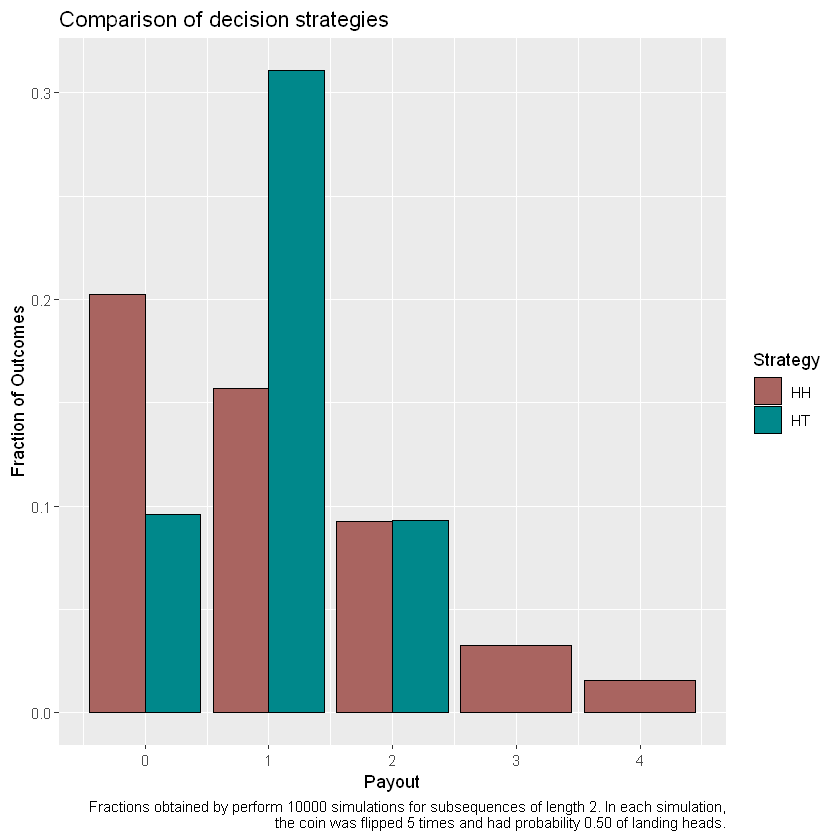

In [33]:
plot_strategies(simulate_experiment(match_seqs))

Ah, the difference is quite stark!

We can use Markov chains as a visual aid for why $HT$ ought to have lower variance than $HH$.

In [52]:
# install.packages("markovchain")

In [4]:
library(markovchain)

Package:  markovchain
Version:  0.6.9.14
Date:     2019-01-20
BugReport: http://github.com/spedygiorgio/markovchain/issues



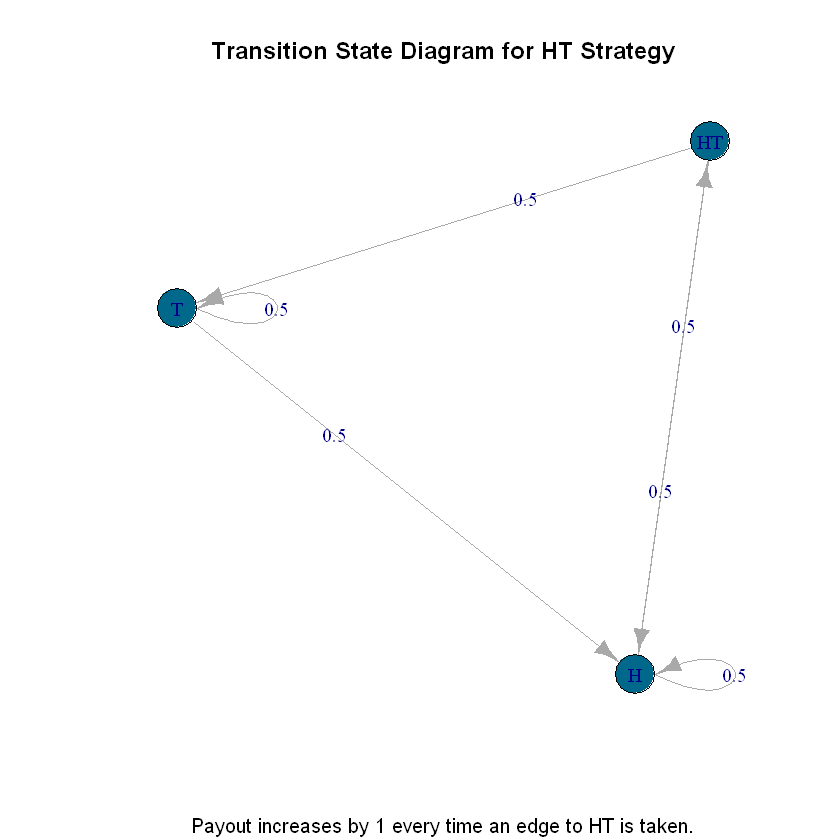

In [14]:
mc_HT <- new("markovchain", states = c("T", "H", "HT"),
             transitionMatrix = matrix(data = c(0.5, 0.5, 0.0,
                                                0.0, 0.5, 0.5,
                                                0.5, 0.5, 0.0), 
                                       byrow = TRUE, 
                                       nrow = 3),
             name = "HT Strategy")
plot(mc_HT,
     main = sprintf("Transition State Diagram for %s", name(mc_HT)),
     sub = "Payout increases by 1 every time an edge to HT is taken."
)

For the $HT$ strategy, there is no way to "lose progress" toward the desired state $HT$. Once you have an $H$, you either stay at $H$ (if another "heads" pops up) or move forward to the reward state $HT$ (if a tails is flipped).

The tradeoff for this "ensured progress" is that once you reach the reward state, you have to be sent back to an earlier state.

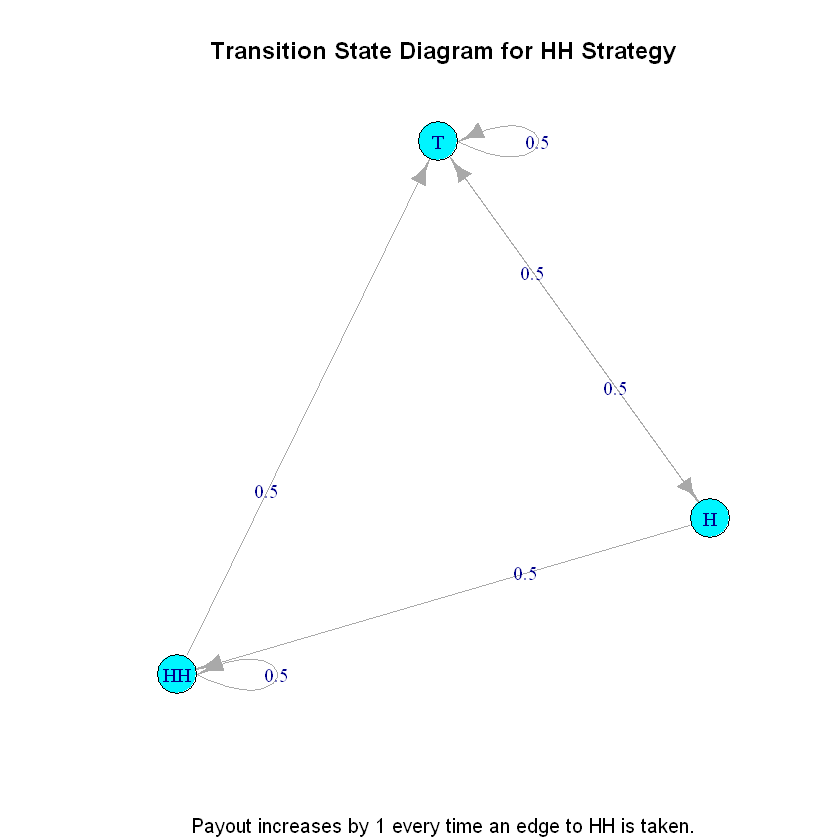

In [33]:
mc_HH <- new("markovchain", states = c("T", "H", "HH"),
                          transitionMatrix = matrix(data = c(0.5, 0.5, 0.0,
                                                              0.5, 0.0, 0.5,
                                                              0.5, 0.0, 0.5), 
                                                    byrow = TRUE, 
                                                    nrow = 3),
                          name = "HH Strategy")
plot(mc_HH,
     main = sprintf("Transition State Diagram for %s", name(mc_HH)),
     sub = "Payout increases by 1 every time an edge to HH is taken."
)

For the $HH$ strategy, one *needs* at least two favorable outcomes in a row for there to be any payoff -- one $T$ resets progress completely.

In exchange for this riskier setup, one gets the possibility of stringing together many rewards in a row (via a long string of $H$'s).

That explains the original problem. But we went through so much effort to make the simulation extensible -- let's see what happens for other situations!

First, let's look at simply increasing the number of flips to, say, 30.

The following `from` values were not present in `x`: FALSE


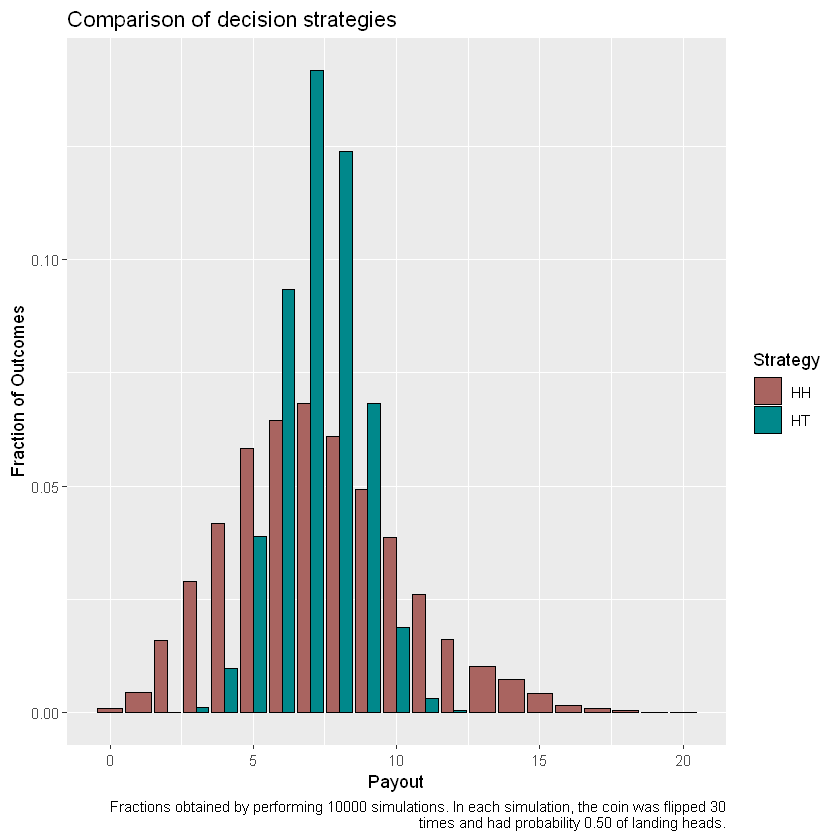

In [37]:
n_rep <- 10000 # should be enough simulations to get a pretty solid estimates


num_flips <- 30


plot_strategies(simulate_experiment(match_seqs), plot_type = 'bar')

Interesting -- the $HH$ strategy is far less lop-sided than it used to be, but still has a noticeable right-tail. We'll comment on that more in a bit -- first, let's try some other strategies.

The following `from` values were not present in `x`: FALSE


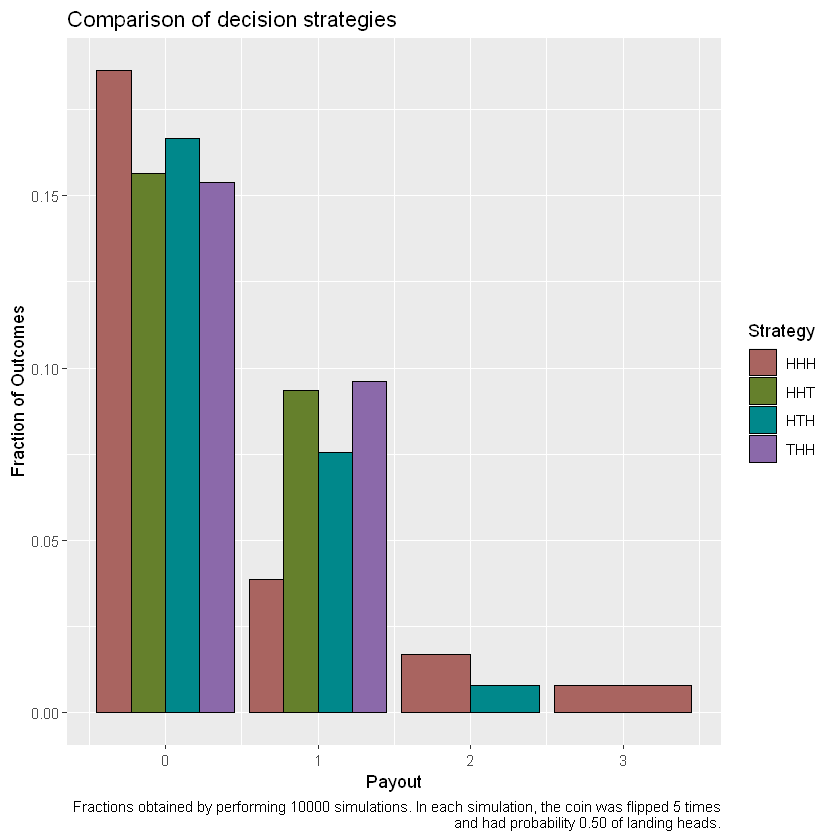

In [51]:
num_flips <- 5
match_seqs <- list(
  c(TRUE, FALSE, TRUE),
  c(FALSE, TRUE, TRUE),
  c(TRUE, TRUE, TRUE),
  c(TRUE, TRUE, FALSE)
)


plot_strategies(simulate_experiment(match_seqs), plot_type = 'bar')

It looks as if $THH$ and $HHT$ would be the choices you'd want if you want to maximize the probability of leaving the game with at least some payout, $HHH$ is aiming for maximum payout, and $HTH$ is a strategy inb etween the two extremes. Let's increase the number of flips to $n = 30$ and see how things look.

The following `from` values were not present in `x`: FALSE


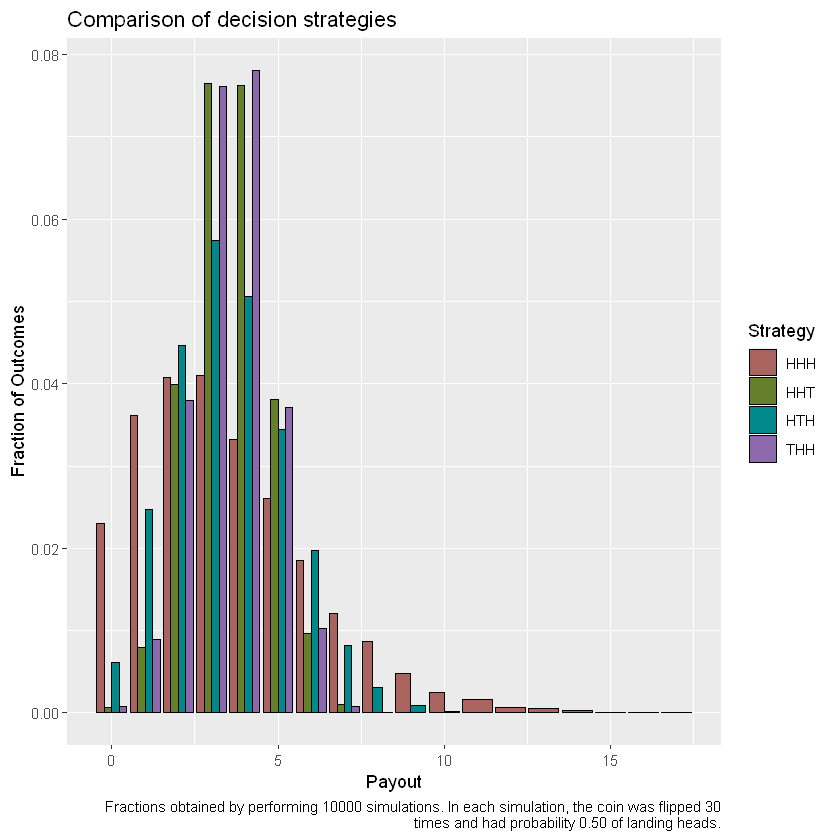

In [42]:
#
# Actual code
#
num_flips <- 30
match_seqs <- list(
  c(TRUE, FALSE, TRUE),
  c(FALSE, TRUE, TRUE),
  c(TRUE, TRUE, TRUE),
  c(TRUE, TRUE, FALSE)
)


plot_strategies(simulate_experiment(match_seqs), plot_type = 'bar')

The $HHT$ and $THH$ strategies mirror each other rather closely, as they both have the same amount of "hedging" -- in theory, they should converge to the exact same distribution with enough simulations. The $HTH$ strategy has slightly less hedging, aiming for possible overlapping substrings (e.g. $HTHTH$, netting a reward of $2$ in a substring of length only $5$ rather than $6$), leading to higher variance. The riskiest of all strategies remains the "all heads" $HHH$ strategy, leaving a long right tail.

Alright, these were for relatively short sequences of coin flips. Let's see what happens to our original two strategies after a ton of coin flips -- say, $n = 500$.

The following `from` values were not present in `x`: FALSE


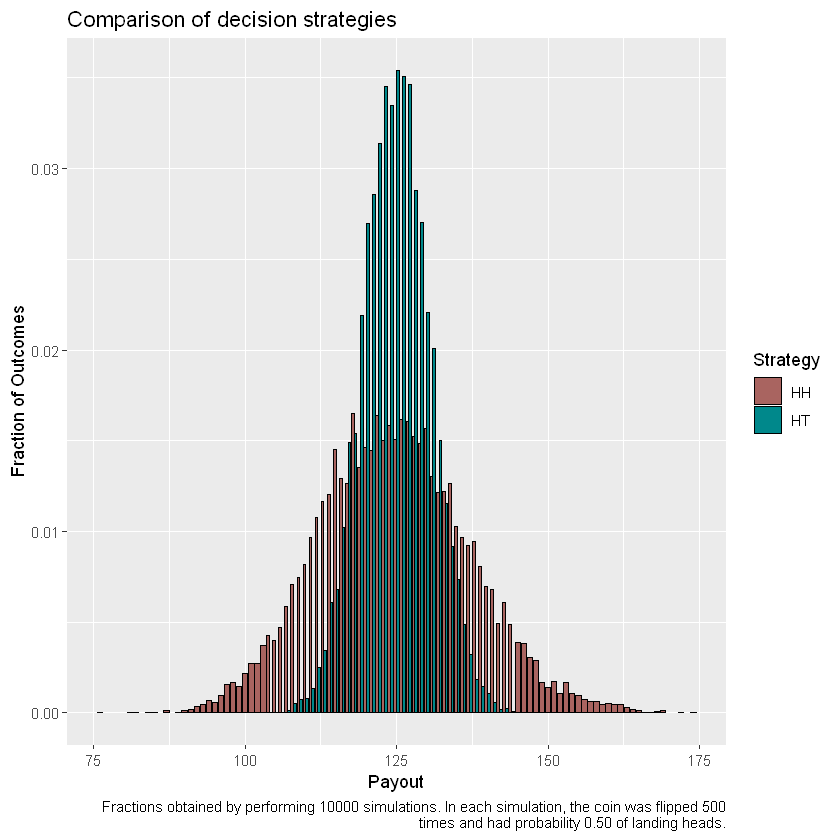

In [45]:
num_flips <- 500
prob_heads <- 0.5

match_seqs <- list(
  c(TRUE, TRUE),
  c(TRUE, FALSE)
)

df_clean <- simulate_experiment(match_seqs)
plot_strategies(df_clean, plot_type = 'bar')

The barplot might be a little messy to look out -- we'll smooth it out with a kernel density estimate.

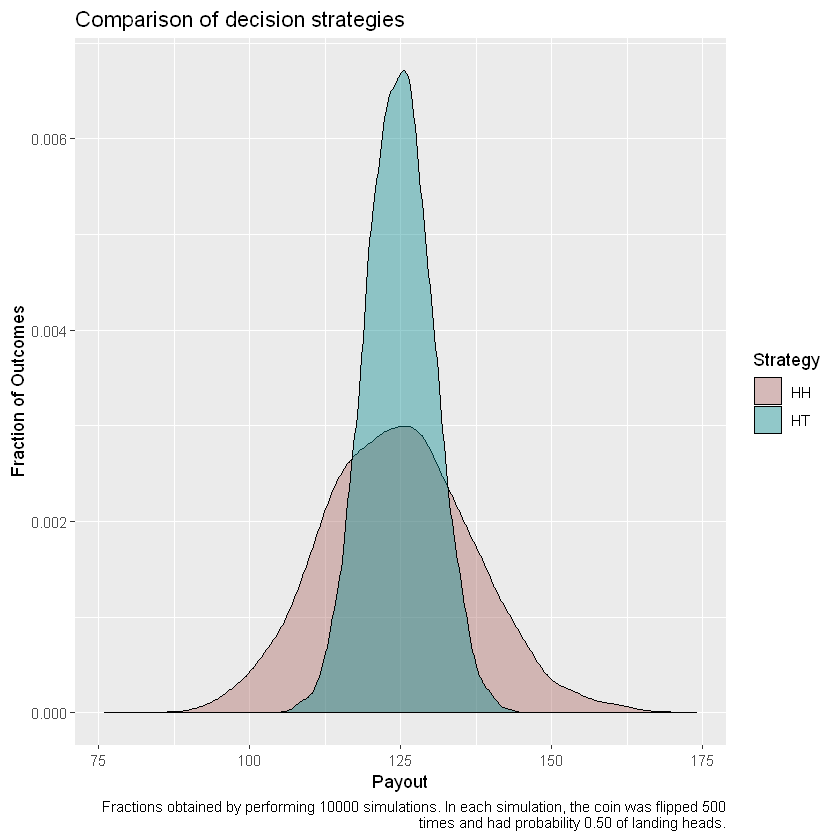

In [47]:
plot_strategies(df_clean, plot_type = 'density')

Those look awfully bell-shaped! Let's see if this also happens for our more complicated strategies:

The following `from` values were not present in `x`: FALSE


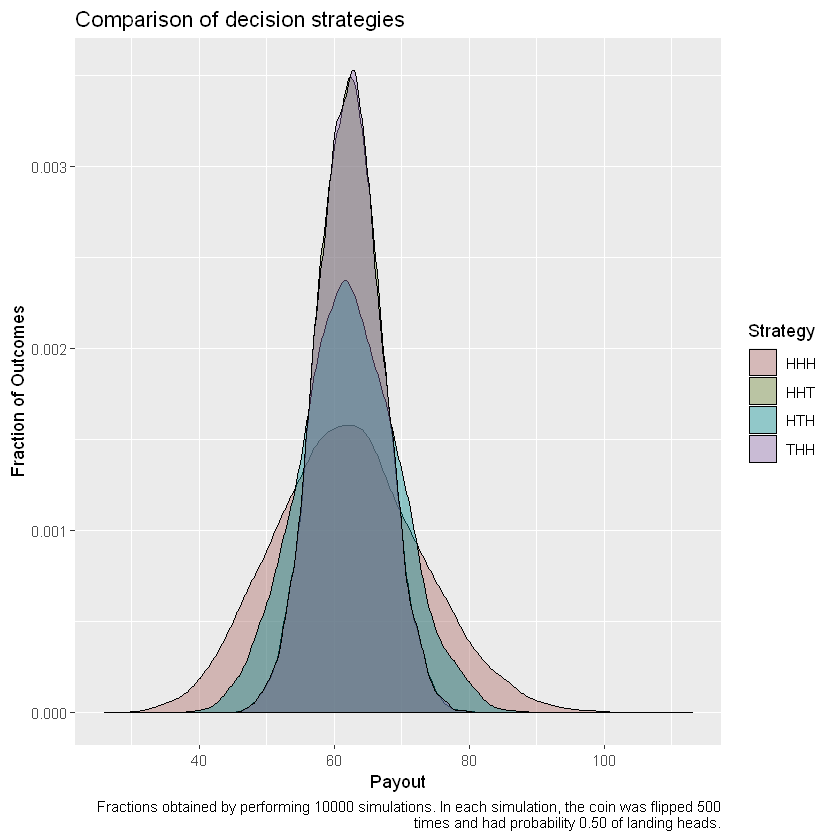

In [50]:
match_seqs <- list(
  c(TRUE, FALSE, TRUE),
  c(FALSE, TRUE, TRUE),
  c(TRUE, TRUE, TRUE),
  c(TRUE, TRUE, FALSE)
)

df_clean <- simulate_experiment(match_seqs)
plot_strategies(df_clean)

Yup, pretty bell-shaped! They are all centered around the same value, but they are spread by different amounts. The riskiest strategy ($HHH$) has the most spread, followed by $HTH$, while $THH$ and $HHT$ essentially perfectly overlap.

What's going on here? Well, we said before that we can break down the payoff $P$ into a sum of indicator variables, more specifically:

$$P_n = \sum_{i=1}^{n-k + 1}X_{i;S,k}$$

where $X_{i;S,k}$ is an indicator variable determining whether the substring of $P_n$ starting at index $i$ matches the substring $S$, which has length $k$.

Note that "nearby" $X_i$'s are dependent on one another! This corresponds to the fact that the substrings they are looking at overlap. However, $|j-i|>k \implies X_i \text{ and } X_j \text{ are independent}$; i.e., indicator variables far enough away from each other are independent. And $P_n$ is the sum of many copies of these indicator variables. Subsets of these indicator variables are pairwise independent, but as $n$ increases, the number of pairwise independent subsets are dwarfed by the many, many subsets of *independent* indicator random variables.

This makes $P_n$ "look" more and more like a sum of independent, identically distributed random variables. And what does that mean? The Central Limit Theorem! And indeed, as $n$ grows larger and larger, the resulting distribution becomes arbitrarily close to a Gaussian with the same mean and variance as the underlying sum of random variables.

But note how large of a difference there is between the distribution of our strategies for $n = 5$ compared to $n = 500$. If we know we'll be in the realm of asymptotic statistics, we are lucky to usually be able to invoke the Central Limit Theorem and simplify our analysis. But we have no such luck when $n = 5$, where simply stating expectations and variances may not provide a full enough picture of the underlying probability mass function. Another example of why it's always important to pay attention to the situation under consideration!

\- DK, 6/17/2019

# Addendum: Symmetry and closer inspection of how the variance varies.

After I shared this notebook on the discussion thread that inspired its creation, the original poster made a few remarks that piqued my interest. I'll quote (emphasis mine):

> *Calvin Lin posted:*
>
> That's a lovely investigation! The 3-coin case is more complicated, so it's great to see your results. *Note that the $THH$ and $HHT$ cases are identical by symmetry (flip the coins and flip the order of the sequence).* For the variance, we indeed have $THH < HTH < HHH$.
>
> *For the general case, I believe that the $TH \ldots H$ case has the lowest variance* (since it requires a $T$ to get it started, so has a very low chance of duplicity). The transition state diagrams also give us some information on how to estimate the variance.

Well, let's check that, shall we? The post has two points:

1. Some strategies are identical by symmetry.
2. "Duplicity" in the sequence (what I'll call *overlap*) is important in determining a strategy's variance.

## Arguments by Symmetry 


We can prove the redundancies in different strategies through bijections.

### (1)

Say we're looking for the number of instances of the subsequence $b$ in the binary string $S$. Denote $\neg S$ as the *binary negation of $S$* (for our $H$ and $T$ scenario, all $H$'s become $T$'s and vice-versa), and denote $mir(S)$ as the *mirror of $S$*, i.e., the sequence as read from right-to-left (rather than left-to-right).

Now, for *any* sequence $s$, the probability of observing $s$ or its mirror are identical: $P(s) = P(mir(s))$. So, given any subsequence $b$ and main sequence $S$, for every event $\omega = \text{b was found k times in S}$, there is a matching event $\omega' = \text{mir(b) was found k times in mir(S)}$. So $P(\omega) = P(\omega')$ and the strategies $b$ and $mir(b)$ are identical.

Now let's assume an equal probability of each individual outcome $P(H) = P(T) = 0.5$. Then in addition to the above, the binary negation of *any* sequence $s$ has the same probability of occurring: $P(\neg s) = P(s)$. So, by an argument that mimics the earlier one, we have that the strategies $b$ and $\not b$ are identical *when each of the binary outcomes have equal probability*. (We can also expand this equivalence class to include both negation and mirroring -- the equivalence class of $b$ is $Eq(b) = \{b, \neg b, mir(b), mir(\neg b)\}$.)

### (2)

We actually alluded to this previously when we visualized the Markov chain description of a few payoff strategies. When $p = 0.5$, payoff strategies such as $g_1 = HHTHH$ and $g_2 = THHTH$ will have identical Markov chain states and transition probababilities, only with different "labels" attached to them (for example, the $HH$ node for $g_1$ would be labeled $TH$ for $g_2$).

## ~~Bread and Circuses~~ Code and Graphs

But enough arguments! Let's see some graphs -- "a picture is worth a thousand words", after all.

In [11]:
# install.packages("collections")
library(collections) # for Stack and Dict

Warning message:
"package 'collections' was built under R version 3.6.1"

In [12]:
# helper functions


convert_to_str <- function(bool_vec){
  # convert boolean vector to string of H's and T's
  
  # let's use plyr::mapvalues
  str_vec <- mapvalues(x = bool_vec, from = c(TRUE, FALSE), to = c("H", "T"))
  paste(str_vec, collapse = '')
}


mirror_str <- function(s){
  # reverse string order, e.g. "HTT" -> "TTH"
  
  k <- strsplit(s, '')[[1]] # strsplit returns list -- just want the one entry
  k <- rev(k)
  mir <- paste(k, collapse = '')
  mir
}




largest_overlap <- function(s){
  #` given a string, determine the largest overlap with itself
  #` e.g. "HHHTTHHH" -> 3 (the beginning "HHH" and the final "HHH")
  #` note: "HHHH" -> 3 (return-value is strictly less than length of s)
  
  v <- strsplit(s,'')[[1]]
  end <- length(v)
  
  for (cur_len in seq(length(v)-1,1)){
    if(all(v[1:cur_len] == v[(end-cur_len+1):end])){
      return(cur_len)
    }
  }
  # if here, no overlap
  return(0)
}

# largest_overlap("HHH")








generate_powerset <- function(n) {
  # generates all boolean vectors of length n
  cur <- c()
  st <- Stack$new()
  st$push(cur)
  res <- list()
  
  while(st$size() > 0){
    cur <- st$pop()
    if(length(cur) == (n-1)){
      # save to res
      # (longer code to prevent a O(2^n) scan across stack
      # just to save to res)
      res <- c(res, list(c(cur, TRUE)))
      res <- c(res, list(c(cur, FALSE)))
    }
    else{
      # add one of each to stack
      st$push(c(cur, TRUE))
      st$push(c(cur, FALSE))
    }
  }
  res
}


filter_vecs <- function(bool_list, exclude_neg = TRUE, exclude_mir = TRUE, exclude_mir_neg = TRUE){
  # Filter out values from bool_list according to boolean flags
  
  
  # using Dicts as hashmaps...
  d_filter <- Dict$new()
  cur_key <- c()
  d_res <- Dict$new()
  
  # initialize hashmaps
  for(e in bool_list){
    key <- convert_to_str(e)
    # keys <- c(keys, list(key))
    d_filter$set(key, 1) # dict of str -> "should_keep"
    d_res$set(key, e) # str -> bool_vec
  }
  
  while(d_filter$size() > 0){
    # take some random key from d_filter, say the first one when calling $keys()
    str_key <- d_filter$keys()[1]
    mir <- mirror_str(str_key)
    
    ## get negation
    k <- d_res$get(str_key)
    # flip bits
    k <- !k
    # convert back to string
    neg <- convert_to_str(k)
    
    # get mirrored negation
    mir_neg <- mirror_str(neg)
    
    
    if(exclude_mir && (str_key != mir))
      d_res$pop(mir, NULL)
    if(exclude_neg)
      d_res$pop(neg, NULL)
    if(exclude_mir_neg)
      d_res$pop(mir_neg, NULL)
    
    # remove "equivalence class" from list we're going through
    d_filter$pop(mir, NULL)
    d_filter$pop(neg, NULL)
    d_filter$pop(mir_neg, NULL)
    d_filter$pop(str_key, NULL)

  }
  
  d_res$values()
}





# for odd exponents, generate_vec(2n+1)
# there seem to be (2^(2n-1) + 2^(n-1)) "unique" terms.
# Proof sketch:
# There are 2^(n+1) self-mirror terms 
# (first n bits are free, last n bits must mirror them, middle bit also free)
# Deal with each portion (self-mirrors and non-mirrors) separately then add back together
#
# for even exponents generate_vec(2n)
# there are exactly (2^(2n-2)) unique terms

In [5]:
# update plotter to handle many factors a bit better

plot_strategies <- function(df_clean, plot_type = c()){
  # plot_type = "bar" or "density"
  
  # referring to http://www.cookbook-r.com/Graphs/Legends_(ggplot2)/
  # among other places for ggplot commands and other R commands
  

  
  
  if (length(plot_type) == 0){
    # some heuristics
    if (num_flips < 50){
      plot_type <- "bar"
    }
    else {
      plot_type <- "density"
    }
  }

  # plot cases  

  if (length(unique(df_clean$flip_type)) > 3 && plot_type == "density"){
    # probably better to just use 'color' attribute...
    # actually, store plot
    # and add facet_wrap() afterward!
    ggplot(df_clean, aes(x = payout, color = flip_type
                         , fill = flip_type
    )) + 
      geom_density(aes(y = (..count..)/sum(..count..)),
                   alpha = 0.1) +
      scale_fill_discrete(name="Strategy", c=50, l = 50) +
      ggtitle("Comparison of decision strategies") +
      labs(x= "Payout", y = "Fraction of Outcomes",
           caption = caption_str)  +
      scale_color_discrete(guide = "none")
  }
  
  else {
    # can get away with prettier fill-in colors
    if (plot_type == "bar"){
      ggplot(df_clean, aes(x = payout, fill = flip_type)) + 
        geom_bar(aes(y = (..count..)/sum(..count..)), position = position_dodge(preserve = "total"), 
                 colour = "black") +
        scale_fill_discrete(name="Strategy", c=50, l = 50) +
        ggtitle("Comparison of decision strategies") +
        labs(x= "Payout", y = "Fraction of Outcomes",
             caption = caption_str)
    }
    else if (plot_type == "density"){
      ggplot(df_clean, aes(x = payout, fill = flip_type)) + 
        geom_density(aes(y = (..count..)/sum(..count..)), 
                     colour = "black", alpha = 0.4) +
        scale_fill_discrete(name="Strategy", c=50, l = 50) +
        ggtitle("Comparison of decision strategies") +
        labs(x= "Payout", y = "Fraction of Outcomes",
             caption = caption_str)
    }
  }
  
  
}

In [27]:
seq_len <- 5
bool_list <- generate_powerset(seq_len)
match_seqs <- filter_vecs(bool_list) # all *possibly* distinct values

n_rep <- 10000 # should be enough simulations to get pretty solid estimates for shorter sequence length


num_flips <- 1000
prob_heads <- 0.5

df_clean <- simulate_experiment(match_seqs)

The following `from` values were not present in `x`: TRUE
The following `from` values were not present in `x`: FALSE
The following `from` values were not present in `x`: TRUE
Warning message in self$remove(key):
"object 'TTTTT' not found"Warning message in self$remove(key):
"object 'TTTTT' not found"Warning message in self$remove(key):
"object 'HHHHH' not found"Warning message in self$remove(key):
"object 'TTHTT' not found"Warning message in self$remove(key):
"object 'TTHTT' not found"Warning message in self$remove(key):
"object 'HHTHH' not found"Warning message in self$remove(key):
"object 'THTHT' not found"Warning message in self$remove(key):
"object 'THTHT' not found"Warning message in self$remove(key):
"object 'HTHTH' not found"Warning message in self$remove(key):
"object 'THHHT' not found"Warning message in self$remove(key):
"object 'THHHT' not found"Warning message in self$remove(key):
"object 'HTTTH' not found"The following `from` values were not present in `x`: FALSE


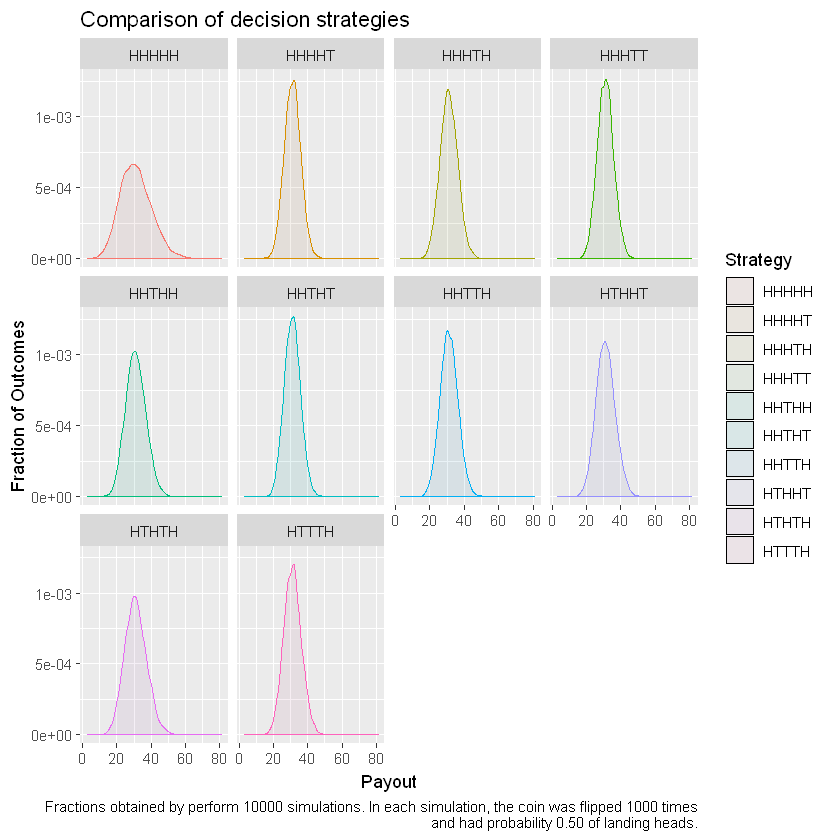

In [9]:
p <- plot_strategies(df_clean)
p +
  facet_wrap(~ flip_type)

Hmm, a lot of these look very similar -- perhaps, as I suspected, the only distinguishing factor between strategies is how much overlap exists with the end and beginning of the sequence? Let's see.

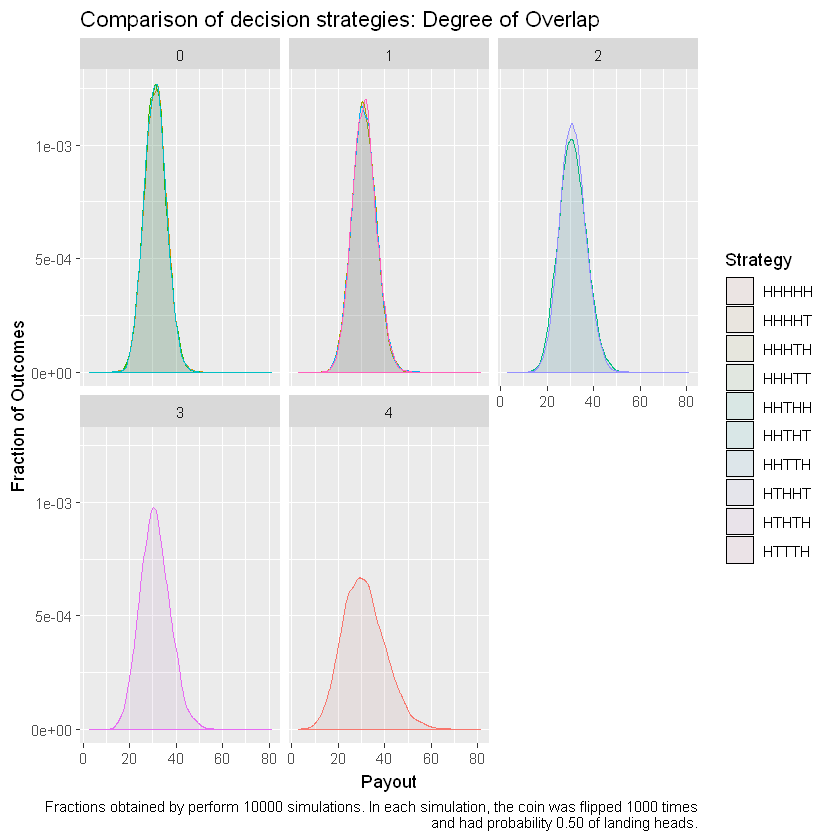

In [17]:
caption_str <- generate_caption(n_rep, num_flips, prob_heads, seq_len)


ggplot(df_clean, aes(x = payout, color = flip_type
                     , fill = flip_type
)) + 
  geom_density(aes(y = (..count..)/sum(..count..)),
               alpha = 0.1) +
  scale_fill_discrete(name="Strategy", c=50, l = 50) +
  ggtitle("Comparison of decision strategies: Degree of Overlap") +
  labs(x= "Payout", y = "Fraction of Outcomes",
       caption = caption_str)  +
  scale_color_discrete(guide = "none") +
    facet_wrap(~ overlap_num)


As we thought! Since all of these random variables are converging to Normal distributions with the same $\mu$, the only differentiating factor is their variance $\sigma^2$, which is governed only by the degree of overlap! This agrees well with our Markov chain analysis from earlier. (We could test this more rigorously by, say, performing pairwise $\chi^2$ goodness-of-fit tests within each grouping and taking conservative values for the degrees of freedom and the test-statistic -- but we'll save such an analysis for another day and another question.)

And how much does the standard deviation normalized by mean, $\sigma/\mu$ (also known as the [coefficient of variation](https://en.wikipedia.org/wiki/Coefficient_of_variation)), change as we increase the level of overlap?

In [15]:
compare_cvs <- function(df_clean){
    
    df_clean <- df_clean %>% rowwise() %>% mutate(overlap_num = largest_overlap(flip_type))
    
    df_stats <- df_clean %>% 
      group_by(overlap_num) %>% 
      summarize(strat_mean = mean(payout), strat_sd = sd(payout))
      # mutate(sd_flip = sd(payout)) %>%



    df_stats <- df_stats %>% rowwise() %>%
            mutate(normalized_sd = strat_sd/strat_mean)

    df_stats <- df_stats %>% mutate(fraction_of_overlap = overlap_num / seq_len)
    
    # ggplot(df_stats, aes(x=reorder(fraction_of_overlap, strat_sd), y = normalized_sd, fill = factor(fraction_of_overlap))) +
    #    geom_col(stat = 'identity', show.legend = FALSE) +
    ggplot(df_stats, aes(x=factor(fraction_of_overlap), y = normalized_sd, fill = factor(fraction_of_overlap))) +
       geom_bar(stat = 'identity', show.legend = FALSE) +
       scale_fill_discrete(name="Strategy", c=50, l = 50) +
       ggtitle("Comparison of decision strategies' coefficients of variation.") +
       labs(x= "Fraction of Subsequence Overlap", y = "Normalized Standard Deviations",
            caption = generate_caption(n_rep, num_flips, prob_heads,seq_len))
    
    }







Warning message:
"Grouping rowwise data frame strips rowwise nature"

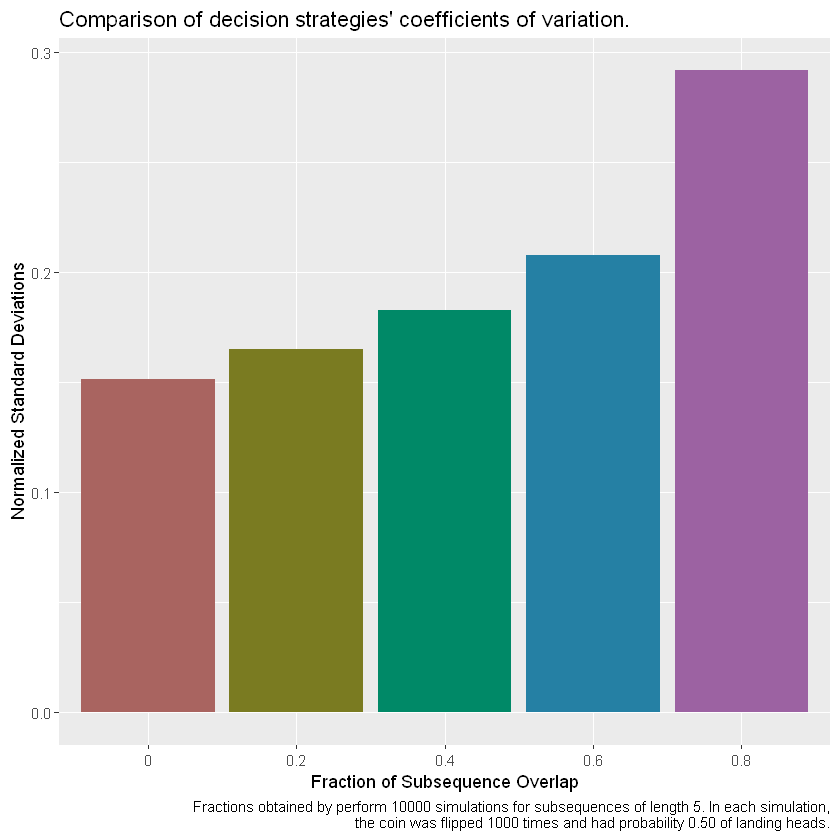

In [28]:
compare_cvs(df_clean)

And does the look of the graph change much if we change the length of the main sequence $n$ from $1000$ to $100$?

In [24]:
seq_len <- 5
bool_list <- generate_powerset(seq_len)
match_seqs <- filter_vecs(bool_list) # all *possibly* distinct values
n_rep <- 10000 # should be enough simulations to get pretty solid estimates for shorter sequence length


The following `from` values were not present in `x`: TRUE
The following `from` values were not present in `x`: FALSE
The following `from` values were not present in `x`: TRUE
Warning message in self$remove(key):
"object 'TTTTT' not found"Warning message in self$remove(key):
"object 'TTTTT' not found"Warning message in self$remove(key):
"object 'HHHHH' not found"Warning message in self$remove(key):
"object 'TTHTT' not found"Warning message in self$remove(key):
"object 'TTHTT' not found"Warning message in self$remove(key):
"object 'HHTHH' not found"Warning message in self$remove(key):
"object 'THTHT' not found"Warning message in self$remove(key):
"object 'THTHT' not found"Warning message in self$remove(key):
"object 'HTHTH' not found"Warning message in self$remove(key):
"object 'THHHT' not found"Warning message in self$remove(key):
"object 'THHHT' not found"Warning message in self$remove(key):
"object 'HTTTH' not found"

The following `from` values were not present in `x`: FALSE
Warning message:
"Grouping rowwise data frame strips rowwise nature"

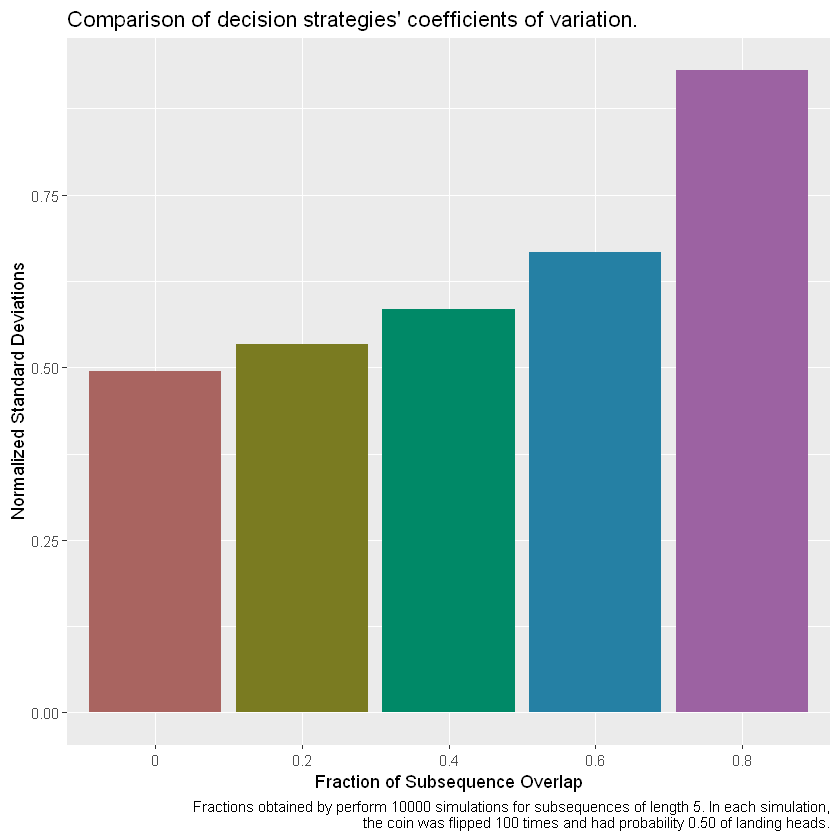

In [25]:
num_flips <- 100


df_clean <- simulate_experiment(match_seqs)
compare_cvs(df_clean)

As suspected -- the shape of the graph stays the same, while the *scale* of the y-axis is stretched.

The factor of stretching itself is somewhat interesting. When $n$ (the length of the total sequence) *decreases* from $n_1$ to $n_2$, we find by inspection that the coefficient of variation *increases* by a factor of 

$$\frac{CV_2}{CV_1} \approx \left|{\log_2\left(\frac{n_2}{n_1}\right)}\right|$$

(If $n$ is *increasing* from $n_1$ to $n_2$, the coefficient of variation *decreases* by the above factor.)

Given that the change in $\mu$ is linear in $n$ (see equation in next section) and recalling that $CV = \frac{\sigma}{\mu}$, we can say the following about how the standard deviation changes with $n$ (assuming $\min(n_1, n_2) \gg k$, the subsequence length of interest):

$$\begin{aligned} \frac{\sigma_2}{\sigma_1} & \approx \frac{\mu_2}{\mu_1} \times \log_2\left(\frac{n_2}{n_1}\right) \\
                                            & \approx \frac{n_2}{n_1} \log_2\left(\frac{n_2}{n_1}\right)
\end{aligned}
$$

This suggests that in general, $\sigma = O(n \log_2(n))$. (And if we wanted, we could fit this form to a plot of $\sigma(n)$ to determine the function's coefficient of best fit.) Neat!

And now, out of curiosity, let's see how this trend looks for larger and larger subsequence size (say $k = 10$).

# Cautionary word: Perform enough simulations.

Before that, a caveat. Recall that the expected number of hits of subsequence $k$ in a sequence of length $n$ is 

$$E[P_{n,k}] = \mu_{n,k} = (n-k+1) \times 2^{-k}$$

(which can be calculated using indicator variables).

Note the two conflicting factors in the expectation expression. The probability of a success decreases *exponentially* with increasing $k$, while an increase in $n$ corresponds to only a linear increase in the expectation. When $E[P_{n,k}]$ gets too small, especially if it becomes much smaller than $1$, you will need a great number of simulations to have the simulated average converge to the true expectation $\mu$. In particular, if $E[P_{n,k}] \approx 10^{-q}$, you will likely want to perform $r = \frac{1}{E[P_{n,k}]} \times 10^p = 10^{q+p}$ simulations (for $p > 3$ or so).

Why? It's a matter of "resolution"; the inherent stochasticity involved in each simulation becomes ever more important when estimating smaller values. Say $E[P_{n,k}] = \mu = 10^{-6}$ and you ran $r = 10^4$ simulations. The "resolution" of our sample mean is how much our sample mean changes when we add $1$ to our total. In general, that is $\frac{1}{r}$; in this case, it's $10^{-4}$. That's a full $100$ times the size of the value we're trying to estimate! So our closest estimate is $\bar{X} = 0$, and the next best possible value is $\bar{X} = 100 \mu$. Which aren't exactly great empirical values for $\mu$. If $r = 1/\mu$, we can potentially actually get $\bar{X} = \mu$, but by just one "extra" or "missing" success, we can have $\bar{X} = 0$ or $\bar{X} = 2\mu$ -- not very stable estimates.

Moral of the story? Having a rough estimate of the size of the value you're trying to estimate via simulation can help make sure you actually perform enough simulations to get a good estimate.

Alright -- back to the show.

In [17]:
generate_overlapping_vec <- function(n,k){
    # generate a (non-unique) boolean vector of length n
    # with "length of overlap" (as described by largest_overlap) of k (< n)


    if((k >= n) || (n <= 0) || (k < 0))
    c()

    # weird indexing... deal with 0 separately
    if(k==0){
    res <- logical(n) # FALSE by default
    res[1] <- TRUE
    return(res)
    }

    # 0 -> F, 1 -> T, -1 -> unspecified by k

    res <- integer(n) - 1
    start_val <- FALSE # arbitrary
    cur <- start_val

    res[seq(n,1,k-n)] <- start_val # tile with T
    res[res==-1] <- !start_val # fill rest with H


    return(as.logical(res))

}



# much more efficient generation method than "powerset -> filter" method (O(n) vs O(2^n))
generate_overlapping_vecs <- function(seq_len){
    # generate one vector that represents a degree of overlap
    # between [0, seq_len - 1]
    res <- list()
    for(i in 0:(seq_len - 1)){
        res <- c(res, list(generate_overlapping_vec(seq_len, i)))
    }
    res
}



# # unit test
# seq_len <- 20
# match_seqs <- generate_overlapping_vecs(seq_len)

# for(i in 1:length(match_seqs)){
#     v <- convert_to_str(match_seqs[[i]])
#     print(largest_overlap(v))
# }

In [18]:
seq_len <- 10
match_seqs <- generate_overlapping_vecs(seq_len)

n_rep <- 100000 # should be enough simulations to get pretty solid estimates


num_flips <- 1000
prob_heads <- 0.5


In [19]:
df_clean <- simulate_experiment(match_seqs)

The following `from` values were not present in `x`: TRUE


In [26]:
# # see raw values

# df_stats <- df_clean %>% rowwise() %>% mutate(overlap_num = largest_overlap(flip_type))

# df_stats <- df_stats %>% 
#   group_by(overlap_num) %>% 
#   summarize(strat_mean = mean(payout), strat_sd = sd(payout))
#   # mutate(sd_flip = sd(payout)) %>%



# df_stats <- df_stats %>% rowwise() %>%
#         mutate(normalized_sd = strat_sd/strat_mean)

# df_stats <- df_stats %>% mutate(fraction_of_overlap = overlap_num / seq_len)

# df_stats

Warning message:
"Grouping rowwise data frame strips rowwise nature"

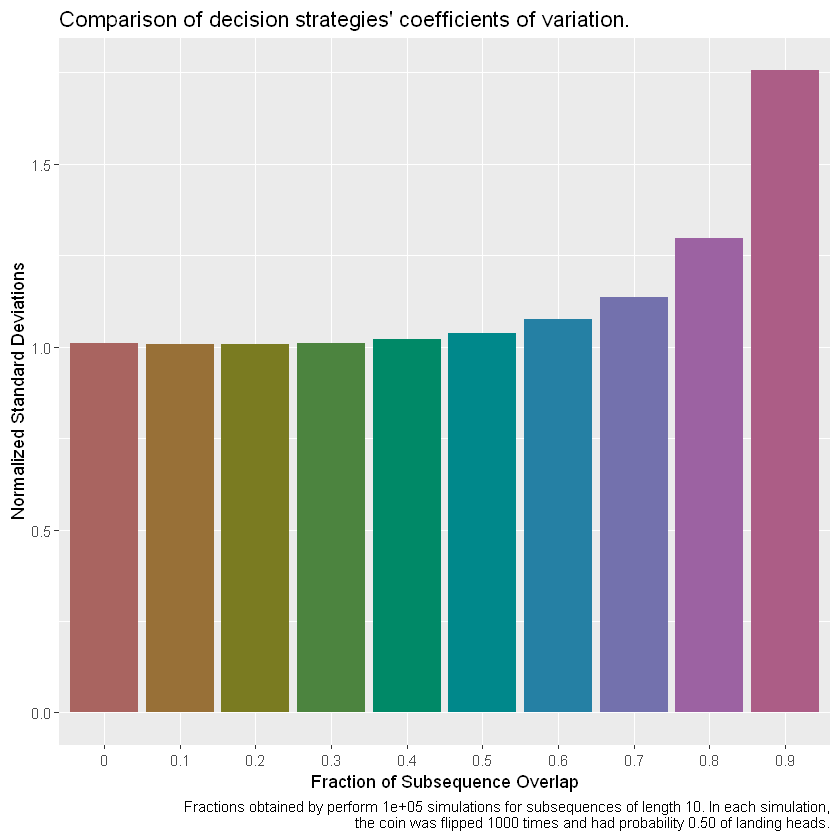

In [20]:
compare_cvs(df_clean)

Interesting! The overlapping strategies only seem to noticeably change the coefficient of variation when the fraction of overlap reaches $0.3$ or so -- and really balloons at the right edge!

# Conclusion

This second look was certainly rewarding. We:

1. determined the equivalence classes of all different subsequences (depending on the value of $p$), 
2. used the coefficient of variation to derive the form of $\sigma(n)$ without deriving it from first principles for arbitrary $k$,
3. discussed the importance of having a fine enough resolution in one's simulations when estimating small values,
4. noted how the variance (or, more specifically, the coefficient of variation) changes in response to subsequence overlap.

That sounds like a wrap!

\- DK, 7/17/19